https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data
    
Sentiment Analysis on Movie Reviews - kaggle 

using the Rotten Tomatoes movie reviews dataset 

## Preprocessing Data

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os

api = KaggleApi()
api.authenticate()

for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    os.remove(f'{file}.zip')

  0%|                                                                                      | 0.00/1.28M [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1.28M/1.28M [00:00<00:00, 6.89MB/s]


100%|███████████████████████████████████████████████████████████████████████████████| 494k/494k [00:00<00:00, 4.19MB/s]

## Preparing Data

In [2]:
import pandas as pd

df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


there are many copies through segments of the same answer - the SentenceId value for each of these copies is identical. We can remove these duplicates. 

In [3]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')

df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


<AxesSubplot:>

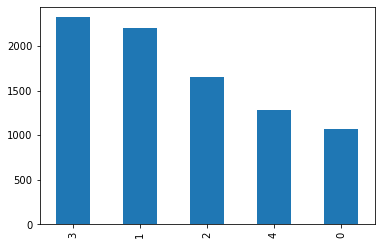

In [4]:
df['Sentiment'].value_counts().plot(kind='bar')

tokenizing this text to create two input tensors; our input IDs, and attention mask.

have tensors within two numpy arrays, which will be of dimensions `len(df) * 512` - the `512` is the sequence length of our tokenized sequences for BERT, and `len(df)` the number of samples in our dataset.

In [5]:
import numpy as np

seq_len = 512
num_samples = len(df)

num_samples, seq_len

(8529, 512)

tokenizing with a `BertTokenizer`

In [6]:
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - Numpy tensors
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

returns three numpy arrays - *input_ids*, *token_type_ids*, and *attention_mask*.

In [7]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [8]:
tokens['input_ids'][:10]

array([[ 101,  138, 1326, ...,    0,    0,    0],
       [ 101, 1188, 3589, ...,    0,    0,    0],
       [ 101, 2431, 3899, ...,    0,    0,    0],
       ...,
       [ 101, 1109,  146, ...,    0,    0,    0],
       [ 101, 1252, 1122, ...,    0,    0,    0],
       [ 101, 1192, 1180, ...,    0,    0,    0]])

In [9]:
tokens['attention_mask'][:10]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

save them to file as Numpy binary files:

In [10]:
with open('movie-ids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-mask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

delete the in-memory arrays to free up memory.

In [11]:
del tokens

target data is a set of integer values (representing sentiment classes) in the Sentiment column of our dataframe 'df'. We need to extract these values and one-hot encode them into another numpy array, which will have the dimensions 'len(df) * number of label classes'. Again, initialize a numpy zero array beforehand, populate using indexing techniques

In [12]:
arr = df['Sentiment'].values

In [13]:
# we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(8529, 5)

We are able to use `arr.max()+1` to define our second dimension here because we have the values *\[0, 1, 2, 3, 4\]* in our *Sentiment* column, there are **5** unique labels which means we need our labels array to have five columns (one for each) - `arr.max() = 4`, so we do `4 + 1` to get our required value of `5`.

Now we use the current values in our `arr` of *\[0, 1, 2, 3, 4\]* to place `1` values in the correct positions of our presently zeros-only array:

In [14]:
labels[np.arange(num_samples), arr] = 1

labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

one-hot encoded labels array - save this to file as a Numpy binary file.

In [15]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

## Input Pipeline

In [16]:
import numpy as np

with open('movie-ids.npy', 'rb') as f:
    ids = np.load(f, allow_pickle=True)
with open('movie-mask.npy', 'rb') as f:
    mask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

We can take these three arrays and create a TF dataset object with them using `from_tensor_slices` like so:

In [17]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((ids, mask, labels))

dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int32, tf.int32, tf.float64)>

Each sample in our dataset is a tuple containing a single `ids`, `mask`, and `labels` tensor. However, when feeding data into our model we need a two-item tuple in the format **(\<inputs\>, \<outputs\>)**. Now, we have two tensors for our inputs - so, what we do is enter our **\<inputs\>** tensor as a dictionary:

```
{
    'input_ids': <input_id_tensor>,
    'attention_mask': <mask_tensor>
}
```

To rearrange the dataset format we `map` a function that modifies the format

In [18]:
def map_func(input_ids, masks, labels):
    # convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.float64)>

Next, shuffle data, and batch it. take batch sizes of `16` and drop any samples that don't fit evenly into chunks of 16.

In [19]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.float64)>

In [20]:
split = 0.9

# to calculate how many batches must be taken to create 90% training set
size = int((ids.shape[0] / batch_size) * split)

size

479

In [21]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# free up memory
del dataset

datasets are prepared for our model inputs. Now, save both to file using [`tf.data.experimental.save`]

In [22]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

while loading these files using `tf.data.experimental.load` need to define the tensor `element_spec` - which describes the tensor shape.

In [23]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

use this tuple when loading our data in the next notebook.

In [24]:
val_ds.element_spec == train_ds.element_spec

True

In [25]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

## Build and Train

initialize the Bert model, load as a pretrained model from transformers.

In [26]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

bert.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


define the frame around Bert, 

* Two input layers (one for input IDs and one for attention mask).

* A post-bert dropout layer to reduce the likelihood of overfitting and improve generalization.

* Max pooling layer to convert the 3D tensors output by Bert to 2D.

* Final output activations using softmax for outputting categorical probabilities.

In [27]:
import tensorflow as tf

# two input layers, ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# access the transformer model within our bert object using the bert attribute ( bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

define model, specifying input and output layers. freeze the Bert layer because Bert is already highly trained, and contains a huge number of parameters so will take a very long time to train further. 

In [28]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

model architecture is now setup, initialize training parameters

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

load in our training and validation datasets.

In [30]:
# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)
val_ds = tf.data.experimental.load('val', element_spec=val_ds.element_spec)

# view the input format
train_ds.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.float64)>

train model

In [32]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)

479/479 [==============================] - 15698s 33s/step - loss: 1.5720 - accuracy: 0.2744 - val_loss: 1.5418 - val_accuracy: 0.3056


In [33]:
model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model\assets


INFO:tensorflow:Assets written to: sentiment_model\assets


## Load and Predict

In [34]:
import tensorflow as tf

model = tf.keras.models.load_model('sentiment_model')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

Before making predictions we need to format data, which requires two steps:

* Tokenizing the data using the `bert-base-cased` tokenizer.

* Transforming the data into a dictionary containing 'input_ids' and 'attention_mask' tensors.

In [35]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [36]:
probs = model.predict(prep_data("hello world"))[0]

probs

array([0.10810728, 0.19894856, 0.20835981, 0.2931542 , 0.19143008],
      dtype=float32)

In [37]:
import numpy as np

np.argmax(probs)

3

In [38]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

df = pd.read_csv('test.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [39]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth ."


create and initialize new column - sentiment

In [40]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,3
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .",3
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .,3
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .,1
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth .",3


In [41]:
df.tail()

,PhraseId,SentenceId,Phrase,Sentiment
66220,222281,11851,Not sweet enough to liven up its predictable story and will leave even fans of hip-hop sorely disappointed .,3
66239,222300,11852,"Nasty , ugly , pointless and depressing , even if you hate clowns .",1
66253,222314,11853,"With tightly organized efficiency , numerous flashbacks and a constant edge of tension , Miller 's film is one of 2002 's involvingly adult surprises .",3
66280,222341,11854,They should have called it Gutterball .,1
66287,222348,11855,"A long-winded , predictable scenario .",3
